# Hotel Reservation Cancellation Prediction

Feature definition can be accessed at
https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, f1_score, log_loss, matthews_corrcoef
from scipy.stats import randint

## Data Cleaning & Preprocessing

In [2]:
# importing Dataset
df = pd.read_csv('hotel_bookings.csv')

In [3]:
# membatasi dataset menjadi 5000 data dan variabel yang digunakan
df = df[['hotel', 'is_canceled', 'adults', 'children', 'babies',
'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'booking_changes',
'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
'total_of_special_requests']].head(5000)


In [4]:
# melihat overview dataset secara keseluruhan
df

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4996,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4997,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0
4998,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0


In [5]:
# melihat jumlah kolom/variabel yang diperlukan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        5000 non-null   object 
 1   is_canceled                  5000 non-null   int64  
 2   adults                       5000 non-null   int64  
 3   children                     5000 non-null   float64
 4   babies                       5000 non-null   int64  
 5   meal                         5000 non-null   object 
 6   country                      4998 non-null   object 
 7   market_segment               5000 non-null   object 
 8   distribution_channel         5000 non-null   object 
 9   reserved_room_type           5000 non-null   object 
 10  booking_changes              5000 non-null   int64  
 11  deposit_type                 5000 non-null   object 
 12  days_in_waiting_list         5000 non-null   int64  
 13  customer_type     

Dari data tersebut dapat kita lihat bahwa ada 8 type object, 7 type integer dan 1 type float. Namun perlu diperhatikan bahwa tidak semua tipe data integer ataupun float bersifat categorical. Oleh karena itu, kita perlu membedah lebih dalam mana kolom yang termasuk kategorikal atau tidak.

In [6]:
dfDesc = []

for i in df.columns:
        dfDesc.append([i, df[i].dtypes, df[i].isna().sum(), round((((df[i].isna().sum())/(len(df)))*100),2), 
                    df[i].nunique(), df[i].drop_duplicates().sample(1).values])
pd.DataFrame(dfDesc, columns = ['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,hotel,object,0,0.00,1,[Resort Hotel]
1,is_canceled,int64,0,0.00,2,[0]
2,adults,int64,0,0.00,14,[5]
3,children,float64,0,0.00,4,[10.0]
4,babies,int64,0,0.00,3,[1]
5,meal,object,0,0.00,5,[Undefined]
6,country,object,2,0.04,56,[KOR]
7,market_segment,object,0,0.00,6,[Groups]
8,distribution_channel,object,0,0.00,3,[Corporate]
9,reserved_room_type,object,0,0.00,9,[D]


Data tersebut menunjukkan bahwa dataset yang kita miliki semua bersifat categorical. Selanjutnya kita akan fokus menangani data null pada kolom country.

In [7]:
df[df.isna().any(axis=1)]

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
30,Resort Hotel,0,1,0.0,0,BB,NaN,Direct,Direct,A,2,No Deposit,0,Transient,0,2
4127,Resort Hotel,1,0,0.0,0,SC,NaN,Offline TA/TO,TA/TO,P,0,No Deposit,0,Transient,0,0


Data tersebut menunjukkan adanya row kosong pada dataset sehingga tidak perlu kita gunakan untuk proses lebih lanjut.

In [8]:
df.dropna()

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4996,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4997,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0
4998,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0


In [9]:
# melihat jumlah data Null kembali setelah penghapusan data Null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        5000 non-null   object 
 1   is_canceled                  5000 non-null   int64  
 2   adults                       5000 non-null   int64  
 3   children                     5000 non-null   float64
 4   babies                       5000 non-null   int64  
 5   meal                         5000 non-null   object 
 6   country                      4998 non-null   object 
 7   market_segment               5000 non-null   object 
 8   distribution_channel         5000 non-null   object 
 9   reserved_room_type           5000 non-null   object 
 10  booking_changes              5000 non-null   int64  
 11  deposit_type                 5000 non-null   object 
 12  days_in_waiting_list         5000 non-null   int64  
 13  customer_type     

Data sudah bersih dari Null dan siap untuk digunakan. Data Null digantikan dengan data lain yang diambil dari total dataset.

## EDA

Hal yang perlu diperhatikan adalah:
    1. Memahami profil tamu/konsumen hotel (customer profiling).
    2. Memahami kebiasaan tamu/konsumen hotel (customer behavior).
    3. Analisa perbedaan ciri-ciri transaksi booking yang berhasil dan cancel.

untuk memahami profil konsumen kita perlu lebih fokus melihat sebaran data adults, children, babies, mmarket segment, required car parking spaces.

In [10]:
# mempersempit view agar mudah untuk di analisis
df_profile = df[['adults', 'children', 'babies', 'market_segment', 'required_car_parking_spaces']]

In [11]:
df_profile

,adults,children,babies,market_segment,required_car_parking_spaces
0,2,0.0,0,Direct,0
1,2,0.0,0,Direct,0
2,1,0.0,0,Direct,0
3,1,0.0,0,Corporate,0
4,2,0.0,0,Online TA,0
...,...,...,...,...,...
4995,2,0.0,0,Groups,0
4996,2,0.0,0,Groups,0
4997,2,0.0,0,Groups,0
4998,2,0.0,0,Groups,0


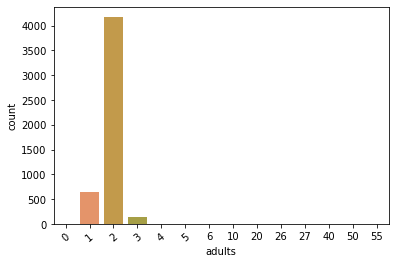

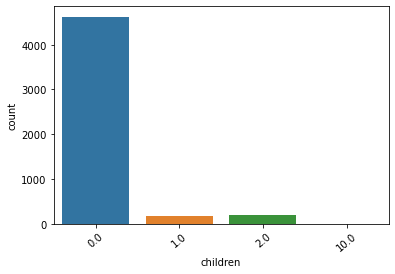

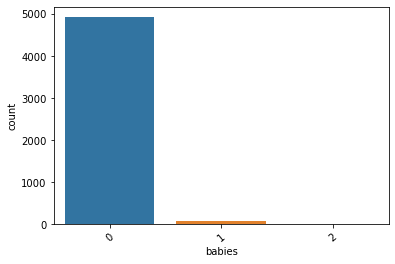

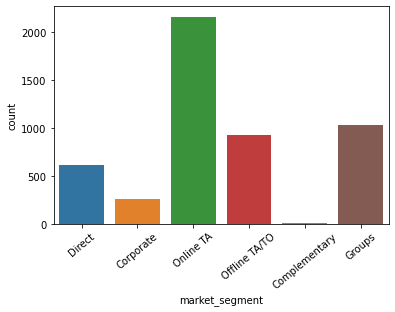

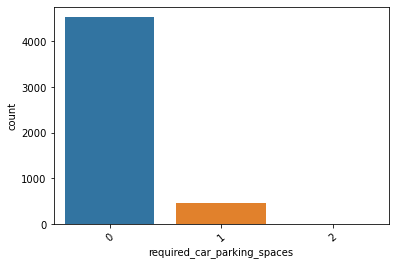

In [12]:
for i in list(df_profile.columns):
    locs, labels = plt.xticks()
    a = sns.countplot(x=i, data=df)
    plt.setp(labels, rotation=40)
    plt.show()

Data tersebut menggambarkan bahwa:
1. Banyaknya tamu jumlah orang dewasa per kamar = 2
2. Mayoritas tamu tidak membawa anak
3. Mayoritas tamu tidak membawa bayi
4. Mayortias tamu berasal dari Travel Agent
5. Mayoritas tamu tidak membutuhkan tempat parkir mobil
Keterangan tersebut menggambarkan karakter tamu yang berkunjung.

Dari data tersebut pun dapat kita ambil keterengan bahwa kebiasaan tamu yang adalah mereka kemungkinan pasangan yang sedang bulang madu atau dalam perjalanan dinas mengingat jarangnya tamu yang membawa keluarga, tidak memerlukan parkir mobil dan kebanyakan dari mereka membeli tiket melalui travel agensi.

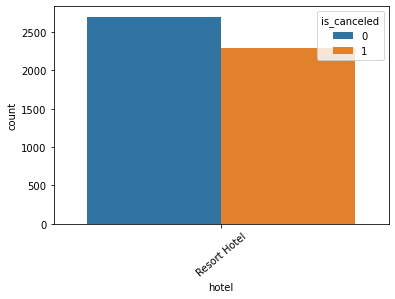

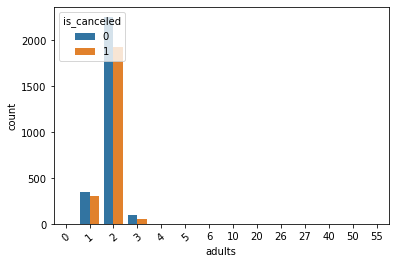

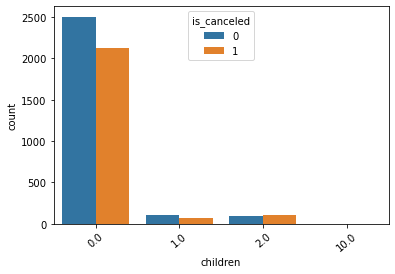

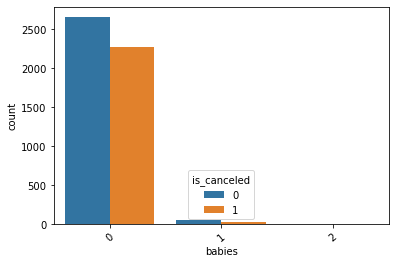

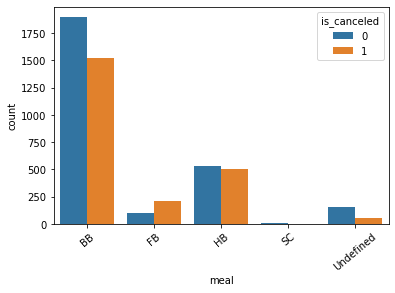

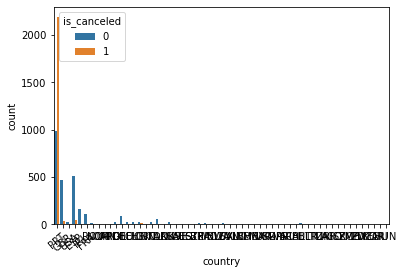

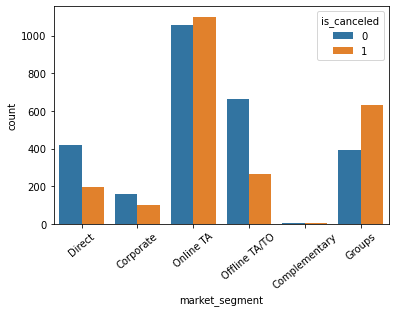

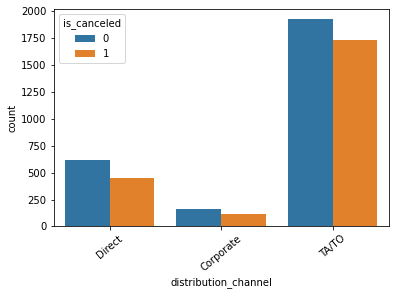

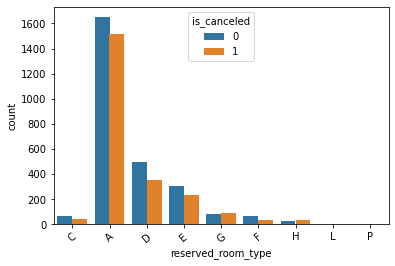

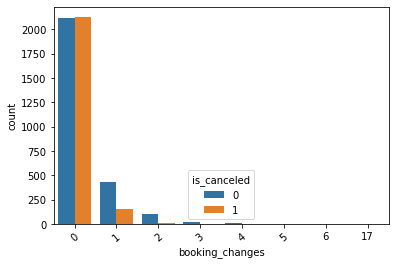

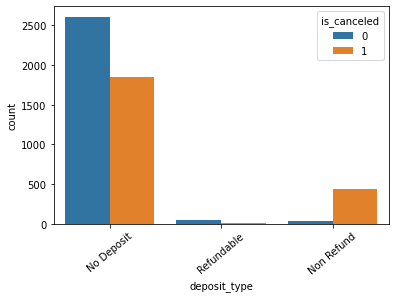

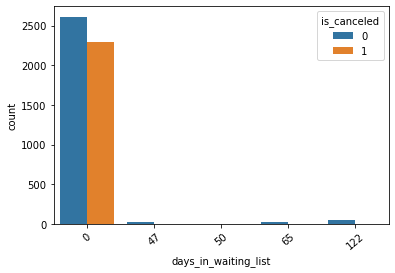

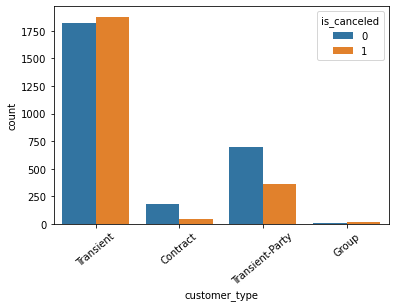

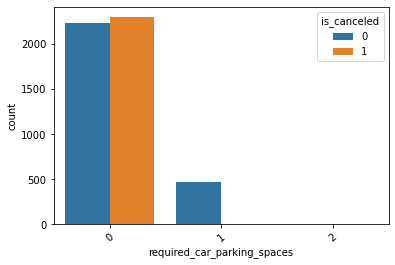

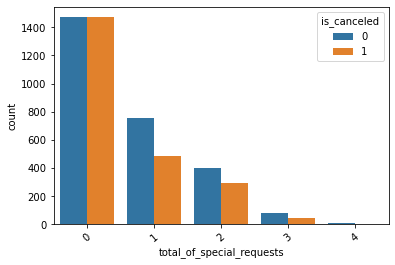

In [13]:
for i in list(df.drop('is_canceled', axis=1).columns):
    locs, labels = plt.xticks()
    a = sns.countplot(x=i, hue='is_canceled', data=df)
    plt.setp(labels, rotation=40)
    plt.show()

Data Tersebut pada dasarnya tidak menjelaskan ciri-ciri yang signifikan menunjukkan adanya variabel yang kuat mempengaruhi tingkat cancel booking tamu. Namun secara garis besar yang perlu kita ketahui adalah tipe customer yang hanya sementara.

## Model Building & Hyper-parameter Tuning

In [14]:
# menentukan variabel dependent dan independet
target = df['is_canceled']
data = df.drop('is_canceled', axis=1)

Dalam kasus ini kami akan menggunakan 3 supervised model yaitu Decision Tree, Random Forest, dan XGBoost

Sebelum melakukan pemodelan terlebih dahulu kita menganalisis target dan melakukan train test split

### Train Test Split

In [15]:
target.to_frame()

,is_canceled
0,0
1,0
2,0
3,0
4,0
...,...
4995,1
4996,1
4997,1
4998,1


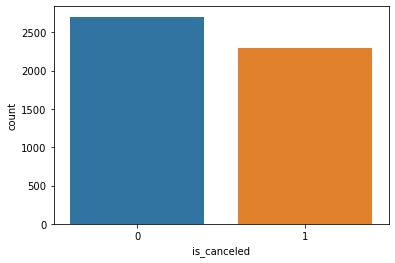

In [16]:
sns.countplot(target)

Target memiliki jumlah yang balance sehingga tidak perlu dilakukan scaler

In [17]:
data

,hotel,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Resort Hotel,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4996,Resort Hotel,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4997,Resort Hotel,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0
4998,Resort Hotel,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, roc_curve,accuracy_score, matthews_corrcoef, auc, log_loss
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [19]:
# melakukan one hot encoding via get_dummies
data = pd.get_dummies(data, drop_first=True)
target = pd.get_dummies(target, drop_first=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    target, 
    random_state=101, test_size=0.3)

In [21]:
# melihat overview data hasil encoding
y_test

,1
1718,1
2511,0
345,0
2521,0
54,0
...,...
3412,0
4020,0
4635,1
1700,0


### Decision Tree

In [22]:
# assign parameter
params_dtree = [{
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,None],
    'criterion' : ['gini', 'entropy']
}]

In [23]:
dtree = DecisionTreeClassifier()

cv = GridSearchCV(dtree, 
                  param_grid=params_dtree, cv=3, verbose=True, n_jobs=-1)

In [24]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 22 candidates, totalling 66 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    2.9s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]}],
             verbose=True)

In [25]:
cv.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [26]:
dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10)

In [27]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

### Random Forest

In [28]:
# assign parameter
params_rf = [{
    'n_estimators' : [1, 5, 10, 50, 100],
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [2, 4, 6, 8, 10],
    'min_samples_split' : [2,5],
    'min_samples_leaf' : [1,2],
    'bootstrap' : [True, False]
}]

rfc = RandomForestClassifier()

In [29]:
cv = GridSearchCV(rfc, param_grid=params_rf, cv=3, verbose=True, n_jobs=-1)

cv.fit(X_train, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1185 out of 1200 | elapsed:   23.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   23.3s finished
C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [2, 4, 6, 8, 10],
                          'max_features': ['auto', 'sqrt'],
                          'min_samples_leaf': [1, 2],
                          'min_samples_split': [2, 5],
                          'n_estimators': [1, 5, 10, 50, 100]}],
             verbose=True)

In [30]:
cv.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
rfc = RandomForestClassifier(bootstrap=False, 
                             max_depth=10, 
                             max_features='auto', 
                             min_samples_leaf=1,  
                             min_samples_split=5, n_estimators=100)

In [ ]:
rfc.fit(X_train, y_train)

### XGBoost

In [33]:
params_xgboost = [{
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth'        : [3, 4, 5, 6, 8, 10, 12, 15],
    'gamma'            : [1, 3, 5, 7],
    'colsample_bytree' : [0.3, 0.4, 0.5, 0.7]
}]

xgb = XGBClassifier()

In [34]:
cv = GridSearchCV(xgb, param_grid=params_xgboost, cv=3, verbose=True, n_jobs=-1)

cv.fit(X_train, y_train)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  6.3min finished
C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [35]:
cv.best_params_

{'colsample_bytree': 0.4, 'gamma': 3, 'learning_rate': 0.2, 'max_depth': 12}

In [36]:
xgb = XGBClassifier(colsample_bytree=0.4, 
                    gamma=3, learning_rate=0.2, max_depth=12)

In [37]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Masing-masing model telah dibuat dan ditetapkan parameter-parameter khusus beserta range nya sehingga kita dapat mengetahui parameter terbaik yang dapat kita gunakan untuk menganalisis data.

## Model Evaluation

Ada 4 point penting yang perlu diperhatikan, point tersebut:

1. Pilih jenis kesalahan yang paling berpengaruh pada kerugian finansial perusahaan dan jelaskan alasan
pilihan Anda!
2. Gunakan serta jelaskan output dari ROC AUC dan Classification Report (Precision, Recall, & Acuracy)!
Setiap evaluasi model , gunakan metode K-Fold Cross Validation untuk semua metric-nya. Tampilkan
seluruh hasil evaluation metric dalam bentuk DataFrame.
3. Jelaskan langkah Anda untuk meningkatkan performa model ML untuk bisa menekan jenis kesalahan
tersebut!
4. Beri kesimpulan di akhir meliputi: 1) model ML yang dipilih, dan 2) impact ke bisnis!

langkah pertama untuk menjabarkan point-point tersebut adalah dengan menjelaskan hasil classification report dan ROC AUC terlebih dahulu.

Adapun penjelasan mengenai Classification report dan ROC AUC, lebih baik kita pahami defini dari Classification report dan ROC AUC

1. Accuracy: proporsi jumlah total prediksi yang benar. Saat kami menggunakannya: Saat kami memiliki target keseimbangan pada set data kereta dan pengujian. Contoh: ketika membangun model untuk mengklasifikasikan spam atau bukan spam dengan target seimbang di set data train dan test.
1. Recall: proporsi kasus positif aktual yang diidentifikasi dengan benar. Ketika kita menggunakannya: ketika kita memiliki target yang tidak seimbang pada set data kereta atau pengujian bersama dengan kita ingin menghitung semua kasus positif aktual masuk Contoh: ketika kita membangun model penipuan, kita tidak ingin penipuan yang sebenarnya tidak terdeteksi.
1. Precision: proporsi kasus positif yang diprediksi yang diidentifikasi dengan benar. Saat kami menggunakannya: ketika kami memiliki target yang tidak seimbang di kereta atau set data pengujian bersama dengan kami ingin menghitung semua kasus positif yang diprediksi masuk. Contoh: Saat kami membuat model rekomendasi video.
1. Kurva FPR-TPR (ROC): grafik yang menunjukkan kinerja model klasifikasi di semua ambang klasifikasi. AUC KOP: Area di bawah kurva KOP. Saat kami menggunakannya: ketika kami ingin mempertimbangkan semua kinerja model pada ambang mana pun bersama dengan kami ingin menghitung semua kasus positif aktual masuk Contoh: ketika kami membangun model penipuan, kami tidak ingin penipuan yang sebenarnya tidak terdeteksi.

### Langkah 1. Membandingkan hasil Classification Report

In [38]:
#dtree
predict = dtree.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87       824
           1       0.81      0.92      0.86       676

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [39]:
#Random Forest
predict = rfc.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       824
           1       0.81      0.95      0.87       676

    accuracy                           0.87      1500
   macro avg       0.88      0.88      0.87      1500
weighted avg       0.89      0.87      0.87      1500



In [40]:
#XGBoost
predict = xgb.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       824
           1       0.82      0.92      0.87       676

    accuracy                           0.87      1500
   macro avg       0.88      0.88      0.87      1500
weighted avg       0.88      0.87      0.87      1500



Dalam kasus dataset ini kita akan fokus pada poin **Recall** karena perusahaan harus benar-benar poin aktual positif yang teridentifikasi benar. Dengan demikian prediksi tamu yang hendak booking secara aktual teridentifikasi benar.

Ketiga Model diatas **Random Forest** lah yang memiliki nilai recall paling tinggi.

### Langkah 2. Melihat AUC ROC

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    target, 
    random_state=101, test_size=0.3)

In [43]:
predictions_proba = xgb.predict_proba(X_test)

In [44]:
predictions_proba

array([[0.16710132, 0.8328987 ],
       [0.9877865 , 0.01221352],
       [0.9985253 , 0.00147468],
       ...,
       [0.00987583, 0.99012417],
       [0.9768126 , 0.02318739],
       [0.18350512, 0.8164949 ]], dtype=float32)

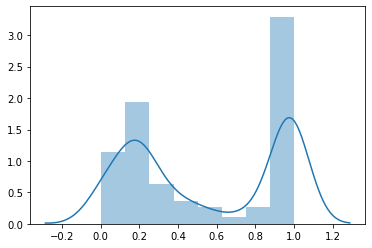

In [45]:
sns.distplot(predictions_proba[:,0])

In [46]:
np.sum(predictions_proba[:,0] < 0.5)/len(predictions_proba)

0.508

In [62]:
dfn = pd.DataFrame()

In [64]:
dfn['pred_score'] = predictions_proba[:,0]

<ipython-input-64-7a28c0d6c696>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['pred_score'] = predictions_proba[:,0]


In [65]:
dfn

,1,pred_score
1718,1,0.167101
2511,0,0.987786
345,0,0.998525
2521,0,0.863219
54,0,0.997801
...,...,...
3412,0,0.968465
4020,0,0.968465
4635,1,0.009876
1700,0,0.976813


In [61]:
df_tmp.drop('y_test', axis=1)
df_tmp

,pred_score,y_test,y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6,y_pred_7,y_pred_8,y_pred_9,y_pred_10
0,0.167101,0.0,0,0,1,1,1,1,1,1,1,1,1
1,0.987786,NaN,0,0,0,0,0,0,0,0,0,0,1
2,0.998525,NaN,0,0,0,0,0,0,0,0,0,0,1
3,0.863219,NaN,0,0,0,0,0,0,0,0,0,1,1
4,0.997801,NaN,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.968465,NaN,0,0,0,0,0,0,0,0,0,0,1
1496,0.968465,NaN,0,0,0,0,0,0,0,0,0,0,1
1497,0.009876,NaN,0,1,1,1,1,1,1,1,1,1,1
1498,0.976813,1.0,0,0,0,0,0,0,0,0,0,0,1


In [69]:
for enum, i in enumerate(np.linspace(0,1,11)):
    dfn['y_pred_{}'.format(enum)] = dfn['pred_score'].apply(
        lambda x: 1 if x < i else 0)

<ipython-input-69-779e778cdaa2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['y_pred_{}'.format(enum)] = dfn['pred_score'].apply(


In [70]:
dfn

,1,pred_score,y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6,y_pred_7,y_pred_8,y_pred_9,y_pred_10
1718,1,0.167101,0,0,1,1,1,1,1,1,1,1,1
2511,0,0.987786,0,0,0,0,0,0,0,0,0,0,1
345,0,0.998525,0,0,0,0,0,0,0,0,0,0,1
2521,0,0.863219,0,0,0,0,0,0,0,0,0,1,1
54,0,0.997801,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412,0,0.968465,0,0,0,0,0,0,0,0,0,0,1
4020,0,0.968465,0,0,0,0,0,0,0,0,0,0,1
4635,1,0.009876,0,1,1,1,1,1,1,1,1,1,1
1700,0,0.976813,0,0,0,0,0,0,0,0,0,0,1


In [71]:
for i in range(0,11):
    tp = len(df_tmp[(df_tmp['y_test'] == 1) & (df_tmp['y_pred_{}'.format(i)] == 1)])
    fn = len(df_tmp[(df_tmp['y_test'] == 1) & (df_tmp['y_pred_{}'.format(i)] == 0)])
    fp = len(df_tmp[(df_tmp['y_test'] == 0) & (df_tmp['y_pred_{}'.format(i)] == 1)])
    recall = tp/(fn + tp)
    errors = fn + fp
    print('recall treshold ke-{} adalah {} dengan errors {}'.format(i,recall,errors))

recall treshold ke-0 adalah 0.0 dengan errors 161
recall treshold ke-1 adalah 0.037267080745341616 dengan errors 155
recall treshold ke-2 adalah 0.5527950310559007 dengan errors 99
recall treshold ke-3 adalah 0.7329192546583851 dengan errors 88
recall treshold ke-4 adalah 0.84472049689441 dengan errors 90
recall treshold ke-5 adalah 0.8944099378881988 dengan errors 95
recall treshold ke-6 adalah 0.9627329192546584 dengan errors 91
recall treshold ke-7 adalah 0.9751552795031055 dengan errors 94
recall treshold ke-8 adalah 1.0 dengan errors 95
recall treshold ke-9 adalah 1.0 dengan errors 104
recall treshold ke-10 adalah 1.0 dengan errors 277


Dengan melihat angka diatas kita memilih treshold ke-8 yaitu 1 karena menghasilkan recall yang paling baik dengan jumlah errors paling sedikit

Dalam kasus ini, sejumlah nilai di FN (False Negative) akan mengakibatkan kerugian finansial aktual kepada perusahaan. Sedangkan sejumlah nilai di FP (False Positive) akan menghilangkan business opportunity kepada perusahaan. Jelas yang paling berpengaruh adalah merupakan kerugian aktual bagi perusahaan.

In [72]:
from sklearn.model_selection import KFold
K = 5
kf =KFold(n_splits = K, shuffle = True, random_state = 42)

In [73]:
def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    matt = matthews_corrcoef(y_train, predictions)
    f1 = f1_score(y_train, predictions, average ='macro')
    report = classification_report(y_train, predictions)
    roc_auc = roc_auc_score(y_train, predictProba[:, 1])
    accuracy = accuracy_score(y_train, predictions)
    confMatrix = confusion_matrix(y_train, predictions)
    logloss = log_loss(y_train,predictProba)
    return{
        'report' : report, 
        'matthew' : matt,
        'f1' : f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'confusion': confMatrix,
        'logloss' : logloss
    }

def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    matt = matthews_corrcoef(y_test, predictions)
    f1 = f1_score(y_test, predictions, average ='macro')
    report = classification_report(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictProba[:, 1])
    accuracy = accuracy_score(y_test, predictions)
    confMatrix = confusion_matrix(y_test, predictions)
    logloss = log_loss(y_test,predictProba)
    return{
        'report' : report, 
        'matthew' : matt,
        'f1' : f1,
        'roc': roc_auc,
        'accuracy': accuracy,
        'confusion': confMatrix,
        'logloss' : logloss
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [74]:
train_errors = []
validation_errors = []
for train_index, val_index in kf.split(data, df['is_canceled']):
    
    #split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    y_train, y_val = df['is_canceled'].iloc[train_index], df['is_canceled'].iloc[val_index]
    
    
    #calculate errors
    train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, xgb)
    
    #append to appropiate list
    train_errors.append(train_error)
    validation_errors.append(val_error)

In [75]:
train_errors

[{'report': '              precision    recall  f1-score   support\n\n           0       0.95      0.84      0.89      2182\n           1       0.83      0.94      0.88      1818\n\n    accuracy                           0.89      4000\n   macro avg       0.89      0.89      0.89      4000\nweighted avg       0.89      0.89      0.89      4000\n',
  'matthew': 0.7805486650559147,
  'f1': 0.8869015760965981,
  'roc': 0.9507853283036827,
  'accuracy': 0.887,
  'confusion': array([[1833,  349],
         [ 103, 1715]], dtype=int64),
  'logloss': 0.2650811792790555},
 {'report': '              precision    recall  f1-score   support\n\n           0       0.94      0.83      0.88      2161\n           1       0.83      0.94      0.88      1839\n\n    accuracy                           0.88      4000\n   macro avg       0.88      0.88      0.88      4000\nweighted avg       0.89      0.88      0.88      4000\n',
  'matthew': 0.7664864806332837,
  'f1': 0.8799543526425924,
  'roc': 0.949807867

In [76]:
for i, tr_err, val_err in zip(range(1,6,1), train_errors, validation_errors):
    print('ROC AUC Train ke {} : {}'.format(i, tr_err['roc']))
    print('ROC AUC Validation ke {} : {}'.format(i, val_err['roc']))

ROC AUC Train ke 1 : 0.9507853283036827
ROC AUC Validation ke 1 : 0.9348317307692308
ROC AUC Train ke 2 : 0.9498078674329322
ROC AUC Validation ke 2 : 0.9365070735626352
ROC AUC Train ke 3 : 0.9536646789656298
ROC AUC Validation ke 3 : 0.9270794861501405
ROC AUC Train ke 4 : 0.9489058700151078
ROC AUC Validation ke 4 : 0.9475609608860307
ROC AUC Train ke 5 : 0.9489029901333133
ROC AUC Validation ke 5 : 0.9487901117574016


In [77]:
for i, tr_err, val_err in zip(range(1,6,1), train_errors, validation_errors):
    print('Accuracy Train ke {} : {}'.format(i, tr_err['accuracy']))
    print('Accuracy Validation ke {} : {}'.format(i, val_err['accuracy']))

Accuracy Train ke 1 : 0.887
Accuracy Validation ke 1 : 0.859
Accuracy Train ke 2 : 0.88
Accuracy Validation ke 2 : 0.878
Accuracy Train ke 3 : 0.88575
Accuracy Validation ke 3 : 0.855
Accuracy Train ke 4 : 0.88075
Accuracy Validation ke 4 : 0.885
Accuracy Train ke 5 : 0.88075
Accuracy Validation ke 5 : 0.872


In [78]:
for i, tr_err, val_err in zip(range(1,6,1), train_errors, validation_errors):
    print(f'Report Train ke {i} :')
    print(tr_err['report'])
    print(f'Report Validation ke {i} :')
    print(val_err['report'])

Report Train ke 1 :
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      2182
           1       0.83      0.94      0.88      1818

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000

Report Validation ke 1 :
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       520
           1       0.82      0.91      0.86       480

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

Report Train ke 2 :
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      2161
           1       0.83      0.94      0.88      1839

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted 

Hasil validasi terbaik berada pada percobaan ke 2 dan 4 dengan hasil recall sebesar 0.94

# DONE